<link rel="preconnect" href="https://fonts.gstatic.com">
<link href="https://fonts.googleapis.com/css2?family=Fira+Code&display=swap" rel="stylesheet">

### License

<p style="font-family: 'Fira Code', monospace; font-size: 1.2rem">
Copyright (C) 2022, Xilinx, Inc.
Copyright (C) 2022-2023, Advanced Micro Devices, Inc.
<br><br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br><br>
You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0"?>http://www.apache.org/licenses/LICENSE-2.0</a><br><br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.<br>
</p>


# IBERT yk scan example

## Description
This example shows how to interact with the IBERT (Integrated Bit Error Ratio Tester) debug core service via ChipScoPy APIs.
- Program the ChipScoPy CED design onto the XCVP1202 device on a VPK120 board
- Verify that the expected IBERT quads are instantiated by the design
- Run and plot YK scans

## Requirements
- Local or remote Xilinx Versal board, VPK120 or VHK158 (only)
- Xilinx hw_server 2023.2 installed and running
- Xilinx cs_server 2023.2 installed and running
- Python 3.8 or greater installed
- ChipScoPy 2023.2 installed
- Jupyter notebook support installed - Please do so, using the command `pip install chipscopy[jupyter]`
- Plotting support installed - Please do so, using the command `pip install chipscopy[core-addons]`
- [External loopback](https://www.samtec.com/kits/optics-fpga/hspce-fmcp/)
- This example assumes that the device has already been programmed with the example design (ie the debug cores have already been initialized)

## 1 - Initialization: Imports

After this step,

* Required functions and classes are imported
* Paths to server(s) and files are set correctly

In [1]:
import os
from more_itertools import one
import matplotlib.pyplot as plt

from chipscopy import create_session, report_versions, report_hierarchy, get_design_files
from chipscopy.api.ibert import create_yk_scans

## 2 - Create a session and connect to the hw_server and cs_server

The session is a container that keeps track of devices and debug cores.
After this step,
- Session is initialized and connected to server(s)
- Versions are detected and reported to stdout

In [2]:
# Specify locations of the running hw_server and cs_server below.
CS_URL = os.getenv("CS_SERVER_URL", "TCP:localhost:3042")
HW_URL = os.getenv("HW_SERVER_URL", "TCP:localhost:3121")

# specify hw and if programming is desired
HW_PLATFORM = os.getenv("HW_PLATFORM", "vpk120")
PROG_DEVICE = os.getenv("PROG_DEVICE", 'True').lower() in ('true', '1', 't')

# The get_design_files() function tries to find the PDI and LTX files. In non-standard
# configurations, you can put the path for PROGRAMMING_FILE and PROBES_FILE below.
design_files = get_design_files(f"{HW_PLATFORM}/production/chipscopy_ced")
PDI_FILE = design_files.programming_file

print(f"PROGRAMMING_FILE: {PDI_FILE}")

session = create_session(cs_server_url=CS_URL, hw_server_url=HW_URL)
report_versions(session)

PROGRAMMING_FILE: /wrk/xcohdnobkup3/dkopelov/chipscopy/chipscopy/examples/designs/vpk120/production/chipscopy_ced/chipscopy_wrapper.pdi


                      ChipScoPy Version Information                      
┌────────────────────────────┬──────────────────────────────────────────┐
│                     Entity │ Version                                  │
├────────────────────────────┼──────────────────────────────────────────┤
│                  ChipScoPy │ ┌───────────┬──────────────────────┐     │
│                            │ │ Attribute │ Value                │     │
│                            │ ├───────────┼──────────────────────┤     │
│                            │ │     Build │ 2023.2.1693353190    │     │
│                            │ │ Timestamp │ Aug 29 2023-17:53:10 │     │
│                            │ └───────────┴──────────────────────┘     │
│                            │                                          │
│ hw_server @ localhost:3121 │ ┌───────────┬──────────────────────────┐ │
│                            │ │ Attribute │ Value                    │ │
│                            │ ├───────────┼──────────────────────────┤ │
│                            │ │    Status │ Connected                │ │
│                            │ │     Build │ 1697249571               │ │
│                            │ │   Version │ 2023.2                   │ │
│                            │ │ Timestamp │ Fri Oct 13 20:12:51 2023 │ │
│                            │ └───────────┴──────────────────────────┘ │
│                            │                                          │
│ cs_server @ localhost:3042 │ ┌───────────────┬──────────────────────┐ │
│                            │ │     Attribute │ Value                │ │
│                            │ ├───────────────┼──────────────────────┤ │
│                            │ │        Status │ Connected            │ │
│                            │ │         Build │ 1696910516           │ │
│                            │ │       Version │ 2023.2.0             │ │
│                            │ │     Timestamp │ Oct 09 2023-22:01:56 │ │
│                            │ │       Package │ 2023.2.1696910516    │ │
│                            │ │ Artifact type │ pyinstaller          │ │
│                            │ └───────────────┴──────────────────────┘ │
└────────────────────────────┴──────────────────────────────────────────┘

## 3 - Program the device with the example design
After this step,
* Device is programmed with the example programming file

In [3]:
# Typical case - one device on the board - get it.
device = session.devices.filter_by(family="versal").get()
if PROG_DEVICE:
    device.program(PDI_FILE)
else:
    print("skipping programming")

--> INFO: Programming device with: 
/wrk/xcohdnobkup3/dkopelov/chipscopy/chipscopy/examples/designs/vpk120/production/chipscopy_ced/chipscopy_wrapper.p
di

Output()

## 4 - Discover and setup the IBERT core

Debug core discovery initializes the chipscope server debug cores.

After this step,

- The cs_server is initialized and ready for use
- The first ibert found is used

In [4]:
# # Set any params as needed
# params_to_set = {"IBERT.internal_mode": True}
# session.set_param(params_to_set)
device = session.devices.filter_by(family="versal").get()

# Use the first available device and set up its debug cores

print(f"Discovering debug cores...")
device.discover_and_setup_cores(ibert_scan=True)

if len(device.ibert_cores) == 0:
    print("No IBERT core found! Exiting...")
    exit()

Discovering debug cores...


## 5 - Print the hierarchy of the IBERT core
We also ensure that all the quads instantiated by the ChipScoPy CED design are found by the APIs

In [5]:
# Use the first available IBERT core from the device
print(f"--> Found {[f'{ibert.name} ({ibert.handle})' for ibert in device.ibert_cores]}\n")

ibert_gtm = one(device.ibert_cores.filter_by(name="IBERT Versal GTM"))

if len(ibert_gtm.gt_groups) == 0:
    print("No GT Groups available for use! Exiting...")
    exit()

print(f"--> Enabled GT Groups - {ibert_gtm.gt_groups}")

gt_group = ibert_gtm.gt_groups.filter_by(name="Quad_204")[0]

--> Found ['IBERT Versal GTM (IBERT_0)', 'IBERT Versal GTYP (IBERT_1)']

--> Enabled GT Groups - [
    'IBERT_0.Quad_205(GT_Group)',
    'IBERT_0.Quad_204(GT_Group)'
]


## 6 - Define YK Scan Update Method

This method will be called each time the yk scan updates, allowing it to update its graphs in real time. 

In [6]:
%matplotlib widget

def yk_scan_updates(obj):
    global count, figure, ax, ax2, ax3
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(range(len(obj.scan_data[-1].slicer)))
            line.set_ydata(list(obj.scan_data[-1].slicer))
    else:
        ax.scatter(range(len(obj.scan_data[-1].slicer)), list(obj.scan_data[-1].slicer), color='blue')
    
    if ax2.lines:
        for line2 in ax2.lines:
            ax2.set_xlim(0, ax2.get_xlim()[1] + len(obj.scan_data[-1].slicer))
            line2.set_xdata(list(line2.get_xdata()) + list(range(len(line2.get_xdata()), len(line2.get_xdata()) + len(obj.scan_data[-1].slicer))))
            line2.set_ydata(list(line2.get_ydata()) + list(obj.scan_data[-1].slicer))
    else:
        ax2.scatter(range(len(obj.scan_data[-1].slicer)), list(obj.scan_data[-1].slicer), color='blue')
        
    if ax3.lines:
        for line3 in ax3.lines:
            if len(obj.scan_data) - 1 > ax3.get_xlim()[1]:
                ax3.set_xlim(0, ax3.get_xlim()[1]+10)
            line3.set_xdata(list(line3.get_xdata()) + [len(obj.scan_data) - 1])
            line3.set_ydata(list(line3.get_ydata()) + [obj.scan_data[-1].snr])
    else:
        ax3.plot(len(obj.scan_data) - 1, obj.scan_data[-1].snr)


    figure.canvas.draw_idle()

## 7 - Create YK Scan

This step initializes the YK scan, setting its update method to the method we defined in the last step. 

In [7]:
yk = create_yk_scans(target_objs=gt_group.gts[0].rx)[0]

yk.updates_callback = yk_scan_updates

## 8 - Run YK Scan

Initialize the plots and start the YK Scan to begin updating the plots. 
YK Scan plot should contain three subplots, these plots should look something like:
![yk_scan_example.png](./yk_scan_example.png)
Note: Depending on the hardware setup and external loopback connection, the plot might look different.

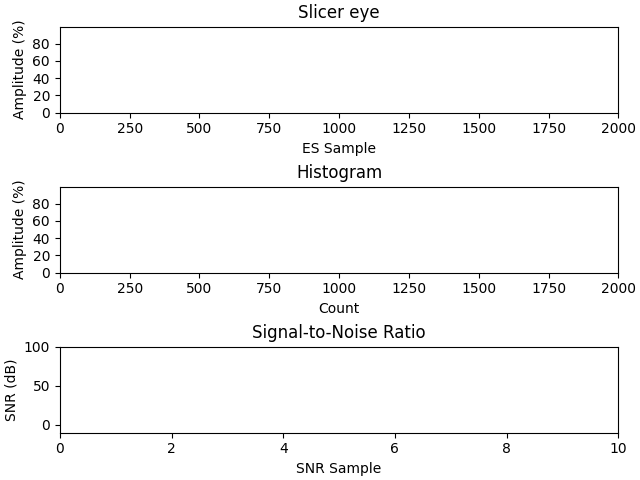

In [8]:
%matplotlib widget

#This sets up the subplots necessary for the 
figure, (ax, ax2, ax3) = plt.subplots(3, constrained_layout = True, num="YK Scan")

ax.set_xlabel("ES Sample")
ax.set_ylabel("Amplitude (%)")
ax.set_xlim(0,2000)
ax.set_ylim(0,100)
ax.set_yticks(range(0, 100, 20))
ax.set_title("Slicer eye")

ax2.set_xlabel("Count")
ax2.set_ylabel("Amplitude (%)")
ax2.set_xlim(0,2000)
ax2.set_ylim(0,100)
ax2.set_yticks(range(0, 100, 20))
ax2.set_title("Histogram")

ax3.set_xlabel("SNR Sample")
ax3.set_ylabel("SNR (dB)")
ax3.set_xlim(0,10)
ax3.set_ylim(-10,100)
ax3.set_title("Signal-to-Noise Ratio")

yk.start()

## 9 - Stop YK Scan
Stops the YK scan from running.

In [ ]:
yk.stop()